In [1]:
"""
trying to run bandits and see the performance of the estimator.

I want to see the failure of the maximum estimator.
Lets set T = sqrt(K) and see if it fails.
"""

using Infiltrator

include("./KjBandits.jl")
using ProgressMeter


In [2]:
function problem_factory(problem_name::String, σ²::Real, seed::UInt32=987; K=-1, alpha=1.0, Delta=0.1)
    if     problem_name == "linear"
        problem = Bandit(collect(0.9:-0.1:0.0), σ², seed)
    elseif     problem_name == "linear_K100"
        problem = Bandit(collect(LinRange(1,0,100)), σ², seed)
    elseif     problem_name == "linear_K20"
        problem = Bandit(collect(LinRange(1,0,20)), σ², seed)
    elseif problem_name == "linear_K2"
        problem = Bandit([0.9,0.5], σ², seed)
    elseif problem_name == "linear_K2_custom"
        problem = Bandit([0.9,0.3], σ², seed)
    elseif problem_name == "poly_K20"
        Delta_ary = ((1:20) ./ 20) .^ alpha
        mu = -Delta_ary
        mu[1] = 0.0
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "equal_K20"
        Delta_ary = Delta*ones(20)
        mu = -Delta_ary
        mu[1] = 0.0
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "equal"
#        Delta_ary = (.1*2)*ones(K) 
        Delta_ary = (.1*16)*ones(K) 
        mu = -Delta_ary
        mu[1] = 0.0
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "allbest"
        mu = zeros(K)
        problem = Bandit(mu, σ², seed)
    elseif problem_name == "alpha_frac_single_gap"
        alphaK = Int(floor(0.7*K))
        Delta_ary = (.1*16)*ones(K) 
        mu = -Delta_ary
        for i in 1:alphaK
            mu[i] = 0.0
        end
        problem = Bandit(mu, σ², seed)
    end
    problem
end

function estimator_factory(name, σ², mu=Float64[], seed=123)
    if (name == "avg")
        est = Average()
    elseif name == "topavg"
        est = TopAverage()
    elseif name == "max"
        est = Max()
    elseif name == "weighted_100"
        est = Weighted(σ², 100, seed)
    elseif name == "weightedms"
        est = WeightedMs(σ²)
    elseif name == "weightedms-gen"
        est = WeightedMsGen(σ²,3)
    elseif name == "weightedms_4"
        est = WeightedMs(σ²,4)
    elseif name == "naiveoracle"
        est = NaiveOracle(mu)
    elseif name == "haver"
        est = Haver(σ²,0.05) # 0.01, 0.05, 0.10
    else
        @error "value error"
    end
    est
end


function algo_factory(algo_name::String, problem::Bandit, seed)
    if algo_name == "ucb"
        algo = Ucb(problem.K, problem.σ², seed=seed)
    elseif algo_name == "sr"
        algo = Rejects(problem.K, seed)
    elseif algo_name == "uniform"
        algo = Uniform(problem.K, seed)
    else
        @error "value error"
    end
    algo
end


algo_factory (generic function with 1 method)

In [ ]:
opt = (σ² = (1.0)^2, 
       dataseed=313, #123
       algoseed=789,
       N = 100, # 20, #50, #100
       n_trials = 200, #50, #1000, # 200
       algo_name = "uniform", # "ucb", # "ucb", "sr", "uniform"
       problem_name = "allbest", #"equal", "allbest", #"linear_K20" #"linear", "linear_K2_custom", "linear_K2"
       K_ary = 2 .^ (3:11), # 3:8, 3:10
)
#estimator_names = ["haver", "naiveoracle", "avg", "max", "weighted_100", "weightedms_4", ]
estimator_names = ["topavg", "naiveoracle", "avg", "max", "weightedms_4", "haver"]
estimator_names = ["topavg", "avg", "max", "haver"]
@show estimator_names
@show opt

hatvalues = zeros(opt.n_trials, length(opt.K_ary), length(estimator_names))
global estimators
global i_t_ary
rng_data = MersenneTwister(opt.dataseed)
rng_algo = MersenneTwister(opt.algoseed) 
rng_algo2 = MersenneTwister(opt.algoseed*31 + 1)
algo = []
problem = []
@showprogress for i_try = 1:opt.n_trials
#    global algo, problem
    myseed = rand(rng_data, UInt32)

    for i_K in eachindex(opt.K_ary)
        global problem, algo
        K = opt.K_ary[i_K]

        problem = problem_factory(opt.problem_name, opt.σ²,  myseed, K=K, alpha=NaN, Delta=NaN)

        algo = algo_factory(opt.algo_name, problem, rand(rng_algo, UInt32))

        myseed2 = rand(rng_algo2, UInt32)
        estimators = [ estimator_factory(name, opt.σ², problem.μ, myseed2) for name in estimator_names]

        # T = convert(Int64, ceil(K^(1.5))) # 1.5 , 2.0
        T = opt.N*K
        for t in 1:T
            i_t = next_arm(algo)
            reward = pull(problem, i_t)
            update!(algo, i_t, reward)
        end

        for i in eachindex(estimators)
            hatvalues[i_try, i_K, i] = estimate_value(estimators[i], algo)
        end
        @assert maximum(problem.μ) == 0.0
    end
    #- compute the bias and the MSE
end
bias = meansqueeze(hatvalues, 1) # n_alphas x n_estimators
mse = meansqueeze(hatvalues .^ 2, 1)
mae = meansqueeze(abs.(hatvalues), 1)


estimator_names = ["topavg", "avg", "max", "haver"]
opt = (σ² = 1.0, dataseed = 313, algoseed = 789, N = 100, n_trials = 200, algo_name = "uniform", problem_name = "allbest", K_ary = [8, 16, 32, 64, 128, 256, 512, 1024, 2048])


Progress:  58%|███████████████████████▊                 |  ETA: 0:03:07

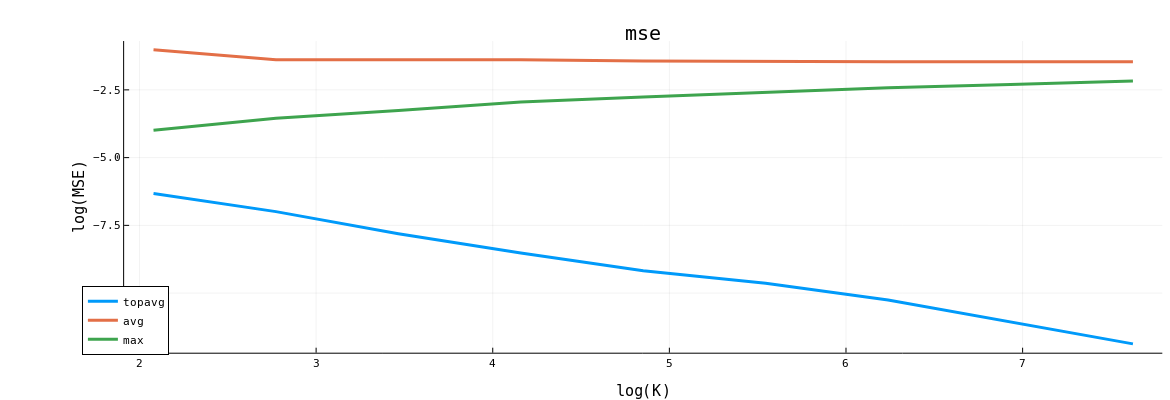

In [15]:
using Plots
plotly()

x = opt.K_ary
i = 1; plot(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3) 
# i = 4; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
# i = 5; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
# i = 6; plot!(log.(x), log.(mse[:,i]), label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="log(MSE)", legend=:bottomleft)  
title!("mse")

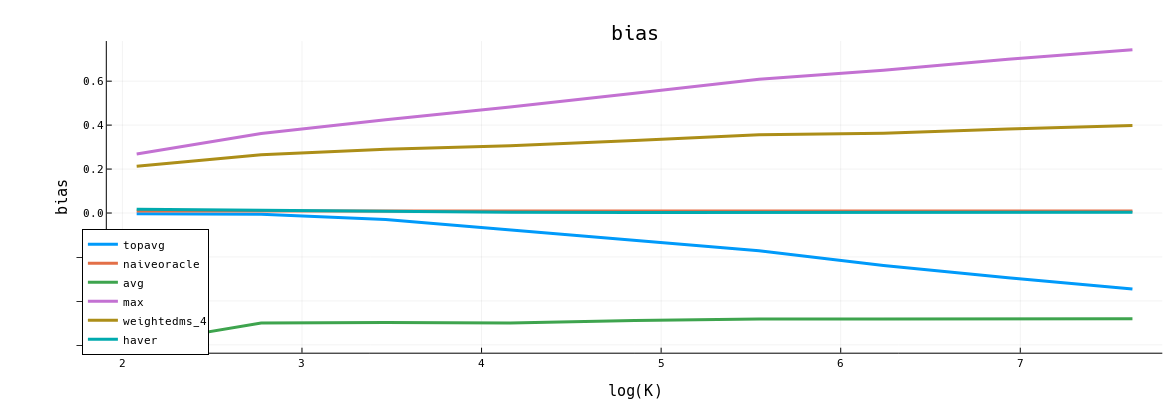

In [11]:
x = opt.K_ary
i = 1; plot(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 2; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 3; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 4; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 5; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
i = 6; plot!(log.(x), bias[:,i], label=estimator_names[i], linewidth=3)
plot!(xlabel="log(K)", ylabel="bias", legend=:bottomleft)  
title!("bias")